# Quantum Elementary Cellular Automata

*Dmytro Fedoriaka, November 2021*

**Abstract.** In this notebook we identify full list of Elementary Cellular Automata rules which can be simulated using reversible quantum computation (there are 22 of them) and for every such rule find corresponding quantum circuit.

## 1.Introduction

### Elementary Cellular Automata

**Elementary Cellular Automaton** ([wikipedia](https://en.wikipedia.org/wiki/Elementary_cellular_automaton), [wolfram](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html)) is 1-dimensional cellular automata. It consists of $N$ cells in a row, each being in state 0 or 1. State of cell on next iteration is defined by a state of this cell and its 2 neigbors on previous iteration.

**Rules.** There are $2^3=8$ possible combinations of state of cell and its neigbors, and to fully define transition rule we ned for every combination specify new state (0 or 1). Therefore, there are $2^8=256$ possible rules and they can be codified by integers from 0 to 255. These integers fully define transitions and are referred to as "[Wolfram codes](https://en.wikipedia.org/wiki/Wolfram_code)" or simply "rules". So, there are in total 256 different Elementary Cellular Automata.

**Border conditions.** To fully define transitions in case of finite $N$ we need to define border conditions. We will consider 2 of them:

* **Periodic**. Leftmost and rightmost cells are considered neighbors.
* **Fixed**. We consider that to the left of first cell and to the right of right cell there is a cell in state 0 which is never updated.


### Simulating ECA by a quantum cirquit

We represent ECA by a registed of $N$ qubits. Quantum state |0> of qubit to represent classical state 0 of cell and quantum state |1> represents classical state 1 of cell. Therefore, each of $2^N$ basis states of quantum register correspond to all possible states of classical ECA. We want for given rule find such a unitary that, when applied to given state, transorms it exactly like classical rule.

In this notebook we don't consider superpositions of basis states and there are no measurements.

### Objective

Objective of this notebook is to find all rules for which it's in principle possible to find corresponding unitary, and for all of them provide instruction how to construct this unitary as a quantum circuit made of $O(N)$ quantum gates acting only on 1,2 or 3 qubits.

## 2. Finding all reversible rules

From our definitions it follows that unitary matrix must map basis states to basis states. Unitary matrix with such property is permutation matrix. So, only a rule which enacts permutation on set of all classical states of ECA can be made into unitary matrix. Indeed, if rule transforms two states A and B into the same state C, it's not reversible, but quantum computation must be reversible.

We use brute force approach to find all reversible rules. For this we check all 256 rules and 2 border conditions. For every of them consider all $2^N$ classical states (encoded as ointegers from 0 to $2^N-1$), and for every of them consider $f(s)$ - encoded state to which rule takes state $s$. Then we check if sequence $0, 1, \dots, d(2^N-1)$ is a permutation. 

We repeat this for a range of $N$ and we hypothesise that if this is a permutation for small $N$, it will be for all $N$. We don't have to prove this hypothesis, because this step is used only to quickly discard irreversible rules. Below for every reversible rule we will construct a unitary and by doing that prove that it's reversible.

In [1]:
import numpy as np
import numba
from matplotlib import pyplot as plt

@numba.jit("u8(u8,u8)")
def get_bit(n, i):
    return (n>>i)%2

@numba.jit("u8(u8,u8,u8,u8)")
def step_fast(rule,p, n, s):
    ans = 0
    for i in range(1, n-1):
        ans += get_bit(rule, 4*get_bit(s,i-1) + 2*get_bit(s,i) + get_bit(s,i+1)) << i
    ans += get_bit(rule, 4*p*get_bit(s,n-1) + 2*get_bit(s,0) + get_bit(s,1))
    ans += get_bit(rule, 4*get_bit(s,n-2) + 2*get_bit(s,n-1) + p*get_bit(s,0)) << (n-1)
    return ans

@numba.jit("u8[:](u8,u8,u8)")
def get_explicit_state_transitions(rule, p, n):
    ans = np.zeros(2**n, dtype=np.uint64)
    for state0 in range(0, 2**n):
        ans[state0]=step_fast(rule, p, n, state0)
    return ans

class ElementaryCA:
    def __init__(self, rule, periodic=1):
        assert rule >=0 and rule < 256
        self.rule = rule
        self.periodic = periodic
    
    def step(self, row0):
        row1 = np.zeros_like(row0)
        n = len(row0)
        for i in range(1, n-1):
            row1[i] = get_bit(self.rule, 4*row0[i-1]+2*row0[i]+row0[i+1])
        row1[0] = get_bit(self.rule, 4*self.periodic*row0[n-1]+2*row0[0]+row0[1])
        row1[n-1] = get_bit(self.rule, 4*row0[n-2]+2*row0[n-1]+self.periodic*row0[0])
        return row1
    
    def simulate_n_steps(self, row0, steps):
        rows = np.zeros((steps, len(row0)), dtype=np.int8)
        rows[0, :] = row0
        for i in range(1, steps):
            rows[i, :] = self.step(rows[i-1, :])
        return rows
    
    def simulate_single_cell(self, size=50):
        row0 = np.zeros(2*size+1, np.int8)
        row0[size] = 1
        return self.simulate_n_steps(row0, size)

    def get_explicit_state_transitions(self, n):
        assert n<=20
        return get_explicit_state_transitions(self.rule, self.periodic, n)

def is_permutation(p):
    return len(set(p))==len(p)

def visualize_rules(rules, periodic=True):
    fig, axs = plt.subplots(1, len(rules), figsize=(15, 20))
    if len(rules)==1: axs = [axs]
    for i in range(len(rules)):
        ca = ElementaryCA(rules[i])
        pic = ca.simulate_single_cell(size=30)
        axs[i].imshow(pic)
        axs[i].set_title('Rule %d' % rules[i])
    plt.show()

In [163]:
for periodic in [0,1]:
    print('Border condition: %s' % ('periodic' if periodic else 'fixed'))
    for rule in range(256):
        good_ns = []
        for n in range(4, 10): # 20
            ca = ElementaryCA(rule, periodic=periodic)
            p = ca.get_explicit_state_transitions(n)
            if is_permutation(p):
                good_ns.append(n) 
        if len(good_ns) > 0:
            print("Rule %d is reversible when n=%s" % (rule, good_ns))
    

Border condition: fixed
Rule 51 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 60 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 90 is reversible when n=[4, 6, 8]
Rule 102 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 105 is reversible when n=[4, 6, 7, 9]
Rule 150 is reversible when n=[4, 6, 7, 9]
Rule 153 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 165 is reversible when n=[4, 6, 8]
Rule 195 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 204 is reversible when n=[4, 5, 6, 7, 8, 9]
Border condition: periodic
Rule 15 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 45 is reversible when n=[5, 7, 9]
Rule 51 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 75 is reversible when n=[5, 7, 9]
Rule 85 is reversible when n=[4, 5, 6, 7, 8, 9]
Rule 89 is reversible when n=[5, 7, 9]
Rule 101 is reversible when n=[5, 7, 9]
Rule 105 is reversible when n=[4, 5, 7, 8]
Rule 150 is reversible when n=[4, 5, 7, 8]
Rule 154 is reversible when n=[5, 7, 9]
Rule 166 is reversible when n=[5, 7, 9]
Rule 170 is reversible wh

Results can be summarized as follows:
    
There are 22 rules which are reversible for at least some values of $N > 3$:    
    
* Rules 51 and 204 - reversible always.
* Rules 15, 85, 170, 240 - reversible for all $N$ at periodic border conditions.
* Rules 45,75,89,101,154,166,180,210 - reversible for odd $N$ at periodic border consitions.
* Rules 105 and 150 - reversible at periodic border conditions if $N \not \equiv 0 (mod 3)$ and at fixed border conditions if $N \not \equiv 2 (mod 3)$.
* Rules 60, 102, 153, 195 - reversible for all $N$ at fixed border consitions.
* Rules 90, 165 - reversible for even $N$ at fixed border conditions.
    

## 3. Algebraic formulas for rules

To help us construct circuits for rules, let's for each rule write down it's formula, i.e. how value of $i$-th cell is computed as function of values of $(i-1)$-th, $i$-th and $(i+1)$-th cells (denoted here as $a_{i-1}, a_i, a_{i+1}$. Here $\oplus$ means addition modulo 2, dot ("$\cdot$") means multiplication (can be also intepreted as AND), $\overline{x} := x \oplus 1$.


* Rule 204: $a_i$ (identity);
* Rule 51: $a_i \oplus 1$ (flips all cells);
* Rule 170: $a_{i+1}$ (left shift);
* Rule 240: $a_{i-1}$ (right shift);
* Rule 15: $a_{i-1}\oplus 1$
* Rule 85: $a_{i+1}\oplus 1$
* Rule 60: $a_{i-1}\oplus a_i$
* Rule 195: $a_{i-1}\oplus a_i \oplus 1$
* Rule 102: $a_i \oplus a_{i+1}$
* Rule 153: $a_{i}\oplus a_{i+1} \oplus 1$
* Rule 90: $a_{i-1}\oplus a_{i+1}$
* Rule 165: $a_{i-1}\oplus a_{i+1} \oplus 1$
* Rule 150: $a_{i-1}\oplus a_{i} \oplus a_{i+1}$
* Rule 105: $a_{i-1}\oplus a_{i} \oplus a_{i+1} \oplus 1$

* Rule 210: $a_{i-1} \oplus (\overline{a_i} \cdot a_{i+1})$
* Rule 45: Rule 210 $\oplus 1$
* Rule 154: $a_{i+1} \oplus (\overline{a_i} \cdot a_{i-1})$
* Rule 101: Rule 154 $\oplus 1$
* Rule 180: $a_{i-1} \oplus (\overline{a_{i+1}} \cdot a_{i})$
* Rule 75: Rule 180 $\oplus 1$
* Rule 166: $a_{i+1} \oplus (\overline{a_{i-1}} \cdot a_{i})$
* Rule 89: Rule 166 $\oplus 1$





## 4. Circuits for rules

The code below generates circuit for every valid rule.

TODO: explain non-trivial circuits.

In [260]:
import cirq

def left_shift(qubits):
    circuit = cirq.Circuit()
    for i in range(len(qubits)-1):
        circuit += cirq.SWAP(qubits[i], qubits[i+1])
    return circuit

def right_shift(qubits):
    circuit = cirq.Circuit()
    for i in range(len(qubits)-2, -1, -1):
        circuit += cirq.SWAP(qubits[i], qubits[i+1])
    return circuit

def circuit_for_eca(rule, qubits, periodic=True):
    """Implements circuit equivalent to one step of given Elementary Cellular Automaton."""
    assert rule >= 0 and rule <= 255, "Invalid rule."
    n = len(qubits)
    assert n >= 3, "Too few qubits."    
    circuit = cirq.Circuit()
    
    if rule == 204:
        # This rule leaves all cells unchanged.
        for i in range(n):
            circuit += cirq.I(qubits[i])
    elif rule == 170:
        # Left shift.
        assert periodic, "This rule requires periodic border condition."
        circuit += left_shift(qubits)
    elif rule == 240:
        # Right shift.
        assert periodic, "This rule requires periodic border condition."
        circuit += right_shift(qubits)
    elif rule == 60:
        # This rule XORs all cells with its left neighbor.
        assert not periodic, "This rule requires fixed border condition."
        for i in range(n-2, -1, -1):
            circuit += cirq.CNOT(qubits[i], qubits[i+1])
    elif rule == 102:
        # This rule XORs all cells with its right neighbor.
        assert not periodic, "This rule requires fixed border condition."
        for i in range(n-1):
            circuit += cirq.CNOT(qubits[i+1], qubits[i])        
    elif rule == 90:
        # This rule replaces cell with XOR of its left and right neigbors.
        assert n % 2 == 0, "This rule requires even N."
        assert not periodic, "This rule requires fixed border condition."
        for i in range(n-3, -1, -1):
            circuit += cirq.CNOT(qubits[i], qubits[i+2])
        for i in range(n-2, 0, -2):
            circuit += cirq.CNOT(qubits[i], qubits[0])
        circuit += left_shift(qubits)        
    elif rule == 150:
        # This rule XORs every cell with its left and right neighbor.
        if periodic:
            assert n % 3 != 0, "This rule requires N%3!=0."
            for i in range(n-1, 1, -1):
                circuit += cirq.CNOT(qubits[i-2], qubits[i])
                circuit += cirq.CNOT(qubits[i-1], qubits[i])
            if n%3 == 2:
                circuit += cirq.SWAP(qubits[0], qubits[1])    
            for i in range(n-1, 0, -1):
                if (n-i) % 3 != 2 and not (i==1 and n%3==2):
                    circuit += cirq.CNOT(qubits[i], qubits[0])
            for i in range(n-1, 1, -1):
                if (n-i) % 3 != 0:
                    circuit += cirq.CNOT(qubits[i], qubits[1])
            circuit += left_shift(qubits)
        else:
            assert n % 3 != 2, "This rule requires N%3!=2."
            for i in range(n-1, 1, -1):
                circuit += cirq.CNOT(qubits[i-2], qubits[i])
                circuit += cirq.CNOT(qubits[i-1], qubits[i])
            circuit += cirq.CNOT(qubits[0], qubits[1])
            for i in range(n-1, 0, -1):
                if (n-i) % 3 != 2:
                    circuit += cirq.CNOT(qubits[i], qubits[0])
            circuit += left_shift(qubits)
    elif rule == 166:
        assert n % 2 == 1, "This rule requires odd N."
        assert periodic, "This rule requires periodic border condition."
        
        def c0mc1not(idx):
            n = len(idx)
            gate = cirq.X.controlled(n-1, [0] + [1]*(n-2))
            return gate(*[qubits[i] for i in idx])
        
        for i in range(n-1, 1, -1):
            circuit += c0mc1not([i-2, i-1, i])    
        for i in range(n//2):
            controls = [2*i+2] + list(range(2*i+3, n, 2)) + [0, 1]
            circuit += c0mc1not(controls)
        for i in range(n//2):
            controls = [2*i+1] + list(range(2*i+2, n, 2)) + [0]
            circuit += c0mc1not(controls)
        circuit += left_shift(qubits)
        
    elif rule in [154, 180, 210]:
        assert n % 2 == 1, "This rule requires odd N."
        assert periodic, "This rule requires periodic border condition."
        raise ValueError("Rule not implemented.")
        # TODO: implement.
    elif rule in [15, 45, 51, 75, 85, 89, 101, 105, 153, 165, 195]:
        # These rules can be implemented as applying other rule followed by flipping all states.
        circuit = circuit_for_eca(255 - rule, qubits, periodic=periodic)
        for i in range(n):
            circuit += cirq.X(qubits[i])
    else:
        raise ValueError("Rule %d can't be implemented as quantum circuit." % ca.rule)
    return circuit


def unitary_for_permutation(p):
    n = len(p)
    ans = np.zeros((n, n), dtype=np.complex128)
    for i in range(n):
        ans[p[i], i] = 1.0
    return ans

def verify(rule, N, periodic=True):
    """Checks that circuit implements unitary corresponding to correct permutation."""
    qubits = cirq.LineQubit.range(N)
    # We inverse qubits because of Cirq's convension about qubits numbering used for matrix construction.
    circuit = circuit_for_eca(rule, qubits[::-1], periodic=periodic)
    unitary_from_circuit = cirq.unitary(circuit)
    p = ElementaryCA(rule, periodic=periodic).get_explicit_state_transitions(N)
    unitary_from_ca = unitary_for_permutation(p)
    #print(np.abs(unitary_from_circuit))
    #print(np.abs(unitary_from_ca))
    #print(unitary_from_circuit.shape)
    #print(unitary_from_ca.shape)
    
    assert np.allclose(unitary_from_circuit, unitary_from_ca)

if False:
    verify(51, 5, periodic=1)
    verify(204, 5, periodic=1)
    verify(170, 5, periodic=1)
    verify(240, 5, periodic=1)
    verify(102, 6, periodic=0)
    verify(90, 6, periodic=0)
    verify(60, 6, periodic=0)


    verify(150, 6, periodic=False)
    verify(150, 7, periodic=False)
    verify(150, 9, periodic=False)
    verify(150, 10, periodic=False)
    verify(150, 10, periodic=True)
    verify(150, 11, periodic=True)

    verify(166, 3, periodic=True)
    verify(166, 5, periodic=True)
    verify(166, 7, periodic=True)
    verify(166, 9, periodic=True)
    
print("OK")

0: ───────────────(0)───@─────@─────X─────X─────×───────────────
                  │     │     │     │     │     │
1: ─────────(0)───@─────X─────X─────(0)───┼─────×───×───────────
            │     │     │     │     │     │         │
2: ───(0)───@─────X─────(0)───┼─────@─────┼─────────×───×───────
      │     │           │     │     │     │             │
3: ───@─────X───────────@─────┼─────┼─────(0)───────────×───×───
      │                       │     │     │                 │
4: ───X───────────────────────(0)───@─────@─────────────────×───
OK


# 5. Some pictures

TODO: clean this up. This section is only illustration, it's not helpful for deriving circuits.

## Rules 51 and 204

These are the most obvious rules. Rule 204 is identity rule which does nothing. Corresponding circuit is empty circuit (or circuit with identity gate at every qubit). Rule 54 flips state of every cell. Corresponding circuit is circuit with X gate on every qubit.

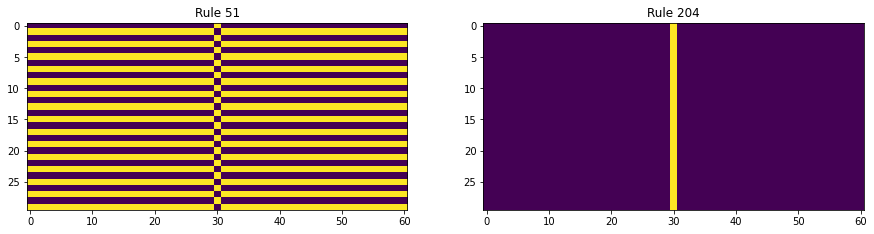

In [6]:
visualize_rules([51, 204])

## Rules 170 and 240

Rule 170 is left shift and rule 240 is right shift. These can be implemented by $N$ SWAP gates.

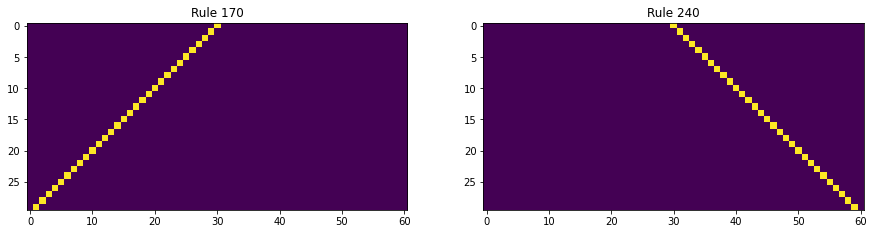

In [7]:
visualize_rules([170, 240])

## Rules 15 and 85

TODO: quantum circuit

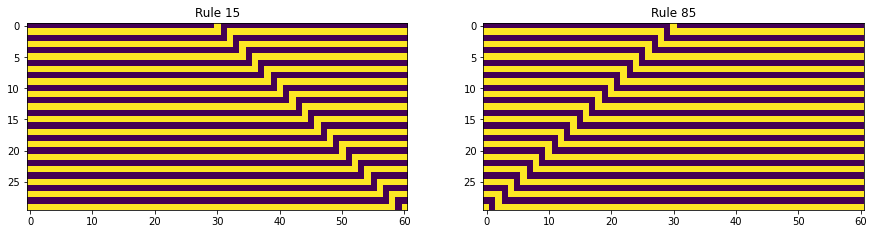

In [8]:
visualize_rules([15, 85])

## Rules 60, 102, 153, 195.

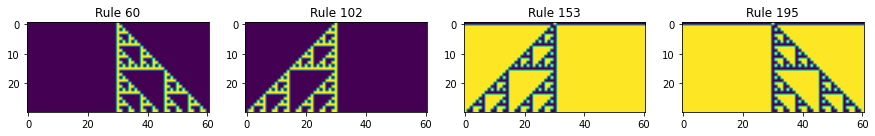

In [9]:
visualize_rules([60, 102, 153, 195])

## Rules 45,75,89 and 101

These rules are reversible for odd $N$ at periodic border conditions.

TODO: quantum circuit.

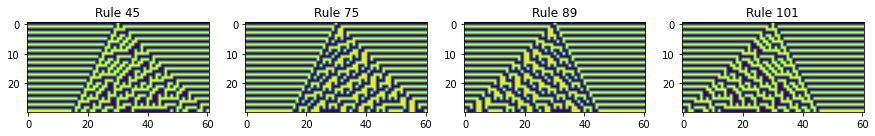

In [10]:
visualize_rules([45,75,89,101])

## Rules 166 and 180

These rules are reversible for odd $N$ at periodic border conditions.

TODO: quantum circuit.

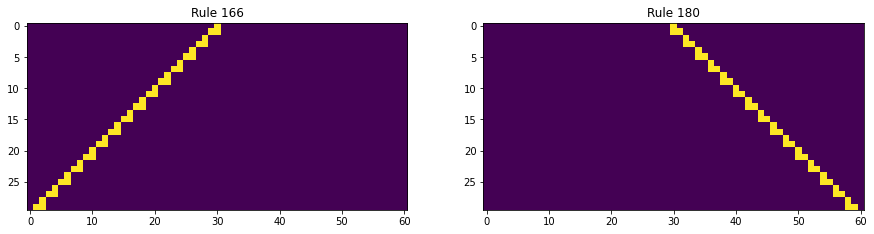

In [11]:
visualize_rules([166,180])

## Rules 154 and 210

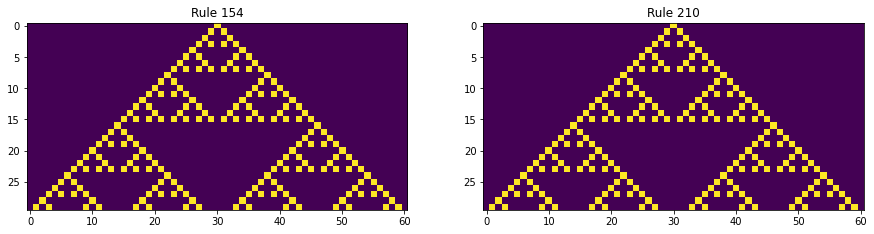

In [12]:
visualize_rules([154,210])

## Rules 90 and 165

Thsse rules are reversible for even $N$ on fixed border conditions.

These rules produce Sierpiński triangles.

[Wolfram article about Rule 90](https://mathworld.wolfram.com/Rule90.html)

TODO: quantum circuit.

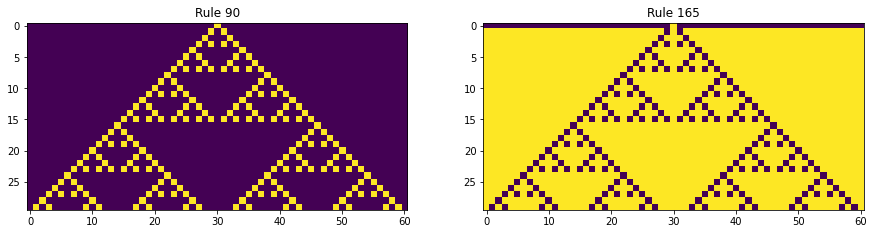

In [12]:
visualize_rules([90, 165])

## Rules 105 and 150

TODO: quantum circuit.

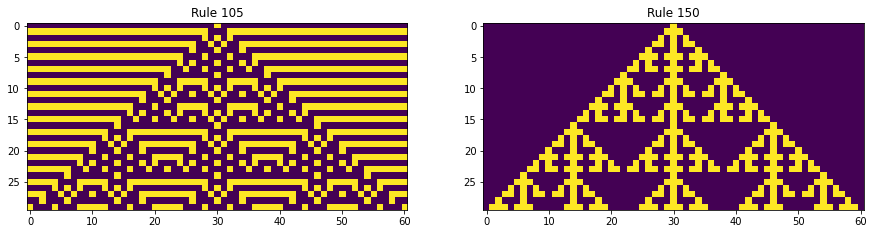

In [13]:
visualize_rules([105, 150])

## Additional results

**Inverses** Of these rules 51 and 204 are inverses of themselves and 170 and 204 are inverses of each other. For all other rules there exists inverse unitary transformation, but it does nto correpsond to any ECA rule.
 
## Notes
Circuits may not be the shortest.

## Further research
1. Fractional time. For every rule $U$ find corresponding Hamiltonian $H$ such that $U = \exp(\frac{i H}{\hbar})$. Then for integer number of iterations $t$, $U^t = \exp(\frac{i H t}{\hbar})$ represents unitary evolving cellulalr automaton $t$ steps forward. But now we can also consider fractional values of $t$ and see state sof ECA "between steps".

2. Evolving superpositions. See what happens if we evolve not from basis state.

3. Check if we allow measurements whether we will be able to simulate non-reversible rules by combination of unitary and measurement in computational basis?

4. Rigorous proofs for all those N conditions.